# Capstone

Michael Schillawski, 10 April 2018

Data Science Immersive, General Assembly

## Imports

In [1]:
import os
import json
import re
import string
import multiprocessing
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.io.json import json_normalize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.feature_extraction.text import CountVectorizer
from joblib import Parallel, delayed
from tqdm import tqdm



%matplotlib inline

os.getcwd()

'/Users/mjschillawski/Google Drive/Data/generalassembly/projects/GitHub Portfolio/capstone_project'

## Load Data

In [2]:
path = '/Users/mjschillawski/Desktop/Miscellaneous Data/Yummly28K/'
file = 'data_records_27638.txt'

data = pd.read_table(path+file,header=None,names=['recipe'],index_col=1)

In [3]:
data.head()

,recipe
1,Mushroom-risotto-352492
2,Filipino-bbq-pork-skewers-352163
3,Mushroom-and-Roasted-Garlic-Risotto-525026
4,Gratin-Dauphinois-_scalloped-Potatoes-With-Che...
5,Delicious-Grilled-Hamburgers-Allrecipes


In [ ]:
data.tail()

,recipe
27634,Saltimbocca-alla-Romana-824004
27635,Carrotini-MyRecipes-241041
27636,Brioche-531830
27637,Mexican-Hot-Chocolate-Doughnuts-501510
27638,Thai-Curry-Burrito-Bowl-with-Sweet-and-Spicy-T...


In [ ]:
path = '/Users/mjschillawski/Desktop/Miscellaneous Data/Yummly28K/metadata27638/'

recipes = []

for i in data.index:
    num = str(i)
    while len(num) < 5:
        num = '0' + num
        
    # https://stackoverflow.com/questions/28373282/how-to-read-a-json-dictionary-type-file-with-pandas
    with open(path+'meta'+num+'.json') as json_data:
        recipe = json.load(json_data)
        recipes.append(recipe)

recipes = json_normalize(recipes)   
recipes

In [ ]:
recipes.to_csv('assets/recipes_dataset.csv')

## EDA

In [ ]:
recipes = pd.read_csv('assets/recipes_dataset.csv',index_col=0)

# transform ingredient field back into list when importing from CSV
recipes['ingredientLines'] = recipes['ingredientLines'].apply(
    lambda x: [item for item in x.split('\'') if item not in ('\,','[',']',', ')])

recipes.head()

In [ ]:
z = recipes.groupby('attributes.course')['ingredientLines']\
    .count().sort_values(ascending=False)
z.head(10)

In [ ]:
print(len(z))

In [ ]:
# distribution of courses
fig, ax = plt.subplots(figsize=(12,10))
ax.bar(z.index[0:10],z[0:10])
_=plt.xticks(fontsize=22,rotation=90)
_=plt.xlabel('Course',fontsize=24)
_=plt.ylabel('Number',fontsize=24)
_=plt.yticks(fontsize=22)
_=plt.title('Recipes by Course',fontsize=28)


In [ ]:
# distribution of cuisines
z = recipes.groupby('attributes.cuisine')['ingredientLines']\
    .count().sort_values(ascending=False)
z.head(17)

In [ ]:
print(len(z))

In [ ]:
# distribution of cuisines
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12,10))
ax.barh(z.index[0:17],z[0:17])
_=plt.xticks(fontsize=22,rotation=90)
_=plt.xlabel('Number',fontsize=24)
_=plt.ylabel('Cuisine',fontsize=24)
_=plt.yticks(fontsize=22)
_=plt.title('Recipes by Cuisine',fontsize=28)


### Extract columns we care about

In [ ]:
short_recipes = recipes[['attributes.course','attributes.cuisine','name','ingredientLines']]

In [ ]:
short_recipes.to_csv('assets/short_recipes.csv')

In [ ]:
short_recipes['ingredientLines'][17464]

## Natural Language Processing for Ingredients

There are a number of components to this. Some are done on an individual, token level. Others are done across ingredients:

**Token**:

- Strip numbers (quantities)
- Strip embedded numbers
- Strip common measurements and their abbreviations
- Strip punctuation
- Strip preparation methods
- Create custom stop word dictionary and remove those words from ingredient list

**Ingredient-level**:

- Inventory a "typical" pantry for expected, common items
    - Fuzzy match pantry items against the ingredients
    - Eliminate those ingredients to reduce recipe complexity

### Preprocessing

#### Single Threaded Parser

In [ ]:
# single-threaded
def process_ingredients(recipes,nondescript=0,drop_words=None):
    # create the patterns

    # import punctuation characters
    # to remove all punctuation
    punct = string.punctuation
    punct_pattern = r"[{}]".format(punct)

    # to remove all numbers
    number_pattern = r"\d+\s"
    
    # embedded numbers
    embed_num_pattern = r".\d+."
    
    # removed prep methods
    prep_pattern = r"[a-z]+ed"
    
    # strip pluralization
    plural_pattern = r"s\s"
    recipes_ingredients = []

    for recipe in recipes:
        ingredients = []
    
        for item in recipe:

            # strip punctuation
            text = re.sub(punct_pattern," ",item)
            # strip standalone numbers
            text = re.sub(number_pattern,"",text)
            # strip embedded numbers
            text = re.sub(embed_num_pattern,"",text)
            # strip preparation methods
            text = re.sub(prep_pattern,"",text)
            # strip pluralization
            text = re.sub(plural_pattern," ",text)
            
            # tokenize
            tokenizer = RegexpTokenizer(r'\w+')
            processed_text = tokenizer.tokenize(text)

            # remove stop words
            processed_text = [text.lower() for text in processed_text if text.lower() 
                              not in stopwords.words('english')]
            
            # remove non-descript recipe words
            if nondescript == 1 and drop_words != None:
                processed_text = [text.lower() for text in processed_text if text.lower()
                                 not in drop_words]
                
            # append all each list that to describe an ingredient of the recipe
            ingredients.append(processed_text)

        # joined space-separated strings
        # attach all modifiers that describe each ingredient (non-separated)
        clean_ingredients = [" ".join(word) for word in ingredients]

        # append all ingredients for each recipe
        recipes_ingredients.append(clean_ingredients)    
    
    recipes_ingredients = [" ".join(ingredient) for ingredient in recipes_ingredients]
    recipes_ingredients = pd.DataFrame(recipes_ingredients)
    return recipes_ingredients

In [ ]:
process_ingredients(short_recipes['ingredientLines'][:5])

#### Multi-Threaded Parser

In [ ]:
# multi-threaded
def multi_process_ingredients(recipes,join=1,
                              nondescript=0,drop_words=None,
                              pantry=0,pantry_items=None):
    # create the patterns

    # import punctuation characters
    # to remove all punctuation
    punct = string.punctuation
    punct_pattern = r"[{}]".format(punct)

    # to remove all numbers
    number_pattern = r"\d+\s"

    # embedded numbers
    embed_num_pattern = r".\d+."
    
    # removed prep methods
    prep_pattern = r"[a-z]+ed"
    
    # strip pluralization
    plural_pattern = r"s\s"
    
    # strip -ly
    ly_pattern = r"[a-z]+ly"
    
    # strip lead number
    lead_pattern = r"\d+[a-z]+"
    lead_repl = r"[a-z]+"
    
    # trail number
    trail_pattern = r"[a-z]+\d+"
    trail_repl = r"[a-z]+"
    
    recipes_ingredients = []
    ingredients = []

    for item in recipes:

        # strip punctuation
        text = re.sub(punct_pattern," ",item)
        # strip standalone numbers
        text = re.sub(number_pattern,"",text)
        # strip embedded numbers
        text = re.sub(embed_num_pattern,"",text)
        # strip preparation methods
        text = re.sub(prep_pattern,"",text)
        # strip pluralization
        text = re.sub(plural_pattern," ",text)
        # strip ly
        text = re.sub(ly_pattern,"",text)
        # lead
        text = re.sub(lead_pattern,lead_repl,text)
        # trail
        text = re.sub(trail_pattern,trail_repl,text)

        # tokenize
        tokenizer = RegexpTokenizer(r'\w+')
        processed_text = tokenizer.tokenize(text)

        # remove stop words
        processed_text = [text.lower() for text in processed_text if text.lower() 
                          not in stopwords.words('english')]
        
        # minimum word length
        processed_text = [text for text in processed_text if len(text) > 2]

        # remove non-descript recipe words
        if nondescript == 1 and drop_words != None:
            processed_text = [text.lower() for text in processed_text if text.lower()
                             not in drop_words]

        # append all each list that to describe an ingredient of the recipe
        ingredients.append(processed_text)

    # joined space-separated strings
    # attach all modifiers that describe each ingredient (non-separated)
    clean_ingredients = [" ".join(word) for word in ingredients]
    
    # remove pantry items
    if pantry == 1 and pantry_items != None:
        clean_ingredients = [text.lower() for text in clean_ingredients if text.lower() not in pantry_items]

    # append all ingredients for each recipe
    recipes_ingredients.append(clean_ingredients)   
    
        
    if join == 0:
        pass
    else:
        recipes_ingredients = [" ".join(ingredient) for ingredient in recipes_ingredients]
    
    return recipes_ingredients

In [ ]:
num_cores = multiprocessing.cpu_count()
inputs = tqdm(short_recipes['ingredientLines'])

if __name__ == "__main__":
    recipes = Parallel(n_jobs=num_cores)(delayed(multi_process_ingredients)(i) for i in inputs)
print(len(recipes))

In [ ]:
recipes

In [ ]:
recipes[0]

In [ ]:
# 1 list of ingredients for each recipe
recipes = [" ".join(recipe) for recipe in recipes]
recipes = pd.DataFrame(recipes)

In [ ]:
recipes.head()

### Word Counts for Custom Stop Word Dictionary

In [ ]:
# word counts
# get the words that occur most often in recipes
# these are candidates for removal in order to simplify the axis that we compare recipes

cvec = CountVectorizer(strip_accents=ascii)
cvecdata = cvec.fit_transform(recipes[0])

cvec_dense  = pd.DataFrame(cvecdata.todense(),
             columns=cvec.get_feature_names())

word_count = cvec_dense.sum(axis=0)    
cw = word_count.sort_values(ascending = False)
print(cw[0:25])

cw_dict = dict(cw)

In [ ]:
# distribution of courses
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(18,12))
plt.bar(cw.index[0:25],cw[0:25])
_=plt.xticks(fontsize=24,rotation=45)
_=plt.xlabel('Word',fontsize=24)
_=plt.ylabel('Number of Occurences',fontsize=24)
_=plt.yticks(fontsize=24)
_=plt.title('Most Frequent Words in Ingredients',fontsize=32)




In [ ]:
# quick function to manually evaluate words that ought to be removed
# https://stackoverflow.com/questions/5844672/delete-an-item-from-a-dictionary

def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

def eval_words(word_list):
    keeps = []
    nondescript = []
    
    nondescript_words = [] 
    keep_words = []
    
    for key,value in word_list.items():
            word_eval = input('Keep {}: {}, y or n?'.format(key,value))
        
            if word_eval == 'n':
                nondescript_words.append(key)
            else:
                keep_words.append(key)
            
            remaining_list = removekey(word_list,key)
            
            if len(nondescript_words) % 100 == 0:
                nondescript = nondescript + nondescript_words
                keeps = keeps + keep_words
                
                # empty holding lists
                keep_words = []
                nondescript_words = []
                
                prompt_continue = input('Continue: yes or no?')
                if prompt_continue == "yes":
                    pass
                else:
                    # export lists as pickles for recovery
                    # store outside the environment to limit reprocessing
                    words_lists = (keeps,nondescript,remaining_list)
                    names = ("keeps","nondescript","remaining")
                    for index,word in enumerate(words_lists):
                        with open("assets/"+names[index]+".pickle","wb") as file:
                            pickle.dump(word,file)
                    return keeps, nondescript,remaining_list
    
    # export word lists for recovery
    # so we don't have to do this multiple times
    words_lists = (keeps,nondescript,remaining_list)
    names = ("keeps","nondescript","remaining")
    for index,word in enumerate(words_lists):
        with open("assets/"+names[index]+".pickle","wb") as file:
            pickle.dump(word,file)
    
    return keep_words, nondescript_words, remaining_list

In [ ]:
# read in pickled results
keep_list = []
drop_list = []

names = ("_keeps","_nondescript")
for name in names:
    for index in range(6):
        with open("assets/"+str(index)+name+".pickle",'rb') as file_handle:
            if name == "_keeps":
                keep_list = keep_list + pickle.load(file_handle)
            elif name == "_nondescript":
                drop_list = drop_list + pickle.load(file_handle)

In [ ]:
# fix human error from ingredient classifications

misclassed_words = ['dice','block','dipping','stems','liter','pestle','2lb','pad','addition','paleo',
                    'smaller','teaspoons','gf','meatles','anytime','xe4utet','almond','scallions',
                    'evoo','wing','non','meal','gala','escarole','nectarine','stuffing','ganache',
                    'speck','hefe','champignon','silver','blade','kabocha','goudak','lindt','quorn',
                    'choi','evoki','aioli','broil','drumette','tex','massamon','pao','steamer','dandelion',
                    'bonnet','rapini','cakes','yucatero','cheek','latin','jimmy','quahog','cone','durum',
                    'cornichons','banh','fryers','quantity','5tbsp','llime','chopping','spam','ink','plant',
                    'triangular','valencia','tubetti','tubettini','cavatelli','perhap','livers','bee',
                    'tartine','teacup','barlett','maker','xlour','jell','fat','free','package'
                   ]

for word in misclassed_words:
    if word in keep_list and word not in drop_list:
        drop_list.append(word)
        keep_list.remove(word)
        print('{} added to drop_list'.format(word))
    elif word in drop_list and word not in keep_list:
        keep_list.append(word)
        drop_list.remove(word)
        print('{} added to keep list'.format(word))
    elif word in drop_list and word in keep_list:
        print('! {} found on both lists !')
    elif word not in drop_list and word not in keep_list:
        print('! {} not found on either list ! You misspelled target word'.format(word))
    else:
        print('! Bigger problems !')

with open("assets/keep_list.pickle","wb") as file:
    pickle.dump(keep_list,file)
with open("assets/drop_list.pickle","wb") as file:
    pickle.dump(drop_list,file)

## Identifying Ingredients in our Pantry

In [ ]:
# re-process ingredient list, this time removing the non-descript words identified above
# getting data ready to identify similiarity with our pantry items

num_cores = multiprocessing.cpu_count()
inputs = tqdm(short_recipes['ingredientLines'])

if __name__ == "__main__":
    recipes_drops = Parallel(n_jobs=num_cores)(delayed(multi_process_ingredients)(i,join=0,
                                                                                  nondescript=1,
                                                                                  drop_words=drop_list
                                                                                 )
                                                                            for i in inputs)

In [ ]:
len(recipes_drops)

In [ ]:
recipes_drops[17464]

### Pantry items

In [ ]:
pantry = ['oregano','garlic powder','ground cumin','onion powder','ground mustard','hot hungarian paprika',
          'mexican oregano','smoked paprika','dill weed','ground turmeric','ground ginger','ground cloves',
         'cumin seed','cayenne pepper','chili powder','ground thyme','celery seed','curry powder',
          'ground white pepper','paprika','ground nutmeg','old bay','maple syrup','thyme leaves',
          'ground black pepper','black pepper','black peppercorns','crushed red pepper flakes','whole oregano',
         'minced onion','fennel seed','cinnamon','dried basil','anise seed','bay leaves','bay leaf',
          'ancho chili powder','ground cloves','coriander','vanilla extract','italian seasoning',
          'apple cider vinegar','honey','corn starch','balsamic vinegar','bread crumbs','white wine vinegar',
         'soy sauce','ketchup','tomato ketchup','red wine vinegar','vegatable oil','canola oil','sherry',
          'baking powder','baking soda','molasses','peanut butter','olive oil','extra virgin olive oil','salt',
          'sea salt','kosher salt','white vinegar','egg','eggs','egg whites','egg yolk','brown sugar','sugar',
          'flour','evoo','butter','salt pepper']

### Pantry processing

In [ ]:
# this eliminates ingredients that have been wholly reduced to blanks
test = [[[ingredient for 
                   ingredient in recipe if ingredient != ''] 
                  for recipe in item] 
                 for item in recipes_drops]

# we're going to take all the ingredients from every recipe and string them together
# then take the set of that to find every unique ingredient
ingredient_master = []
for items in test:
    for recipe in items:
        ingredient_master = list(set(ingredient_master + recipe))
print(len(ingredient_master))

In [ ]:
# from the ingredient_master list, we eliminate ingredients that bear substantial similiarity to our pantry items
# because these ingredients are IN our pantry, they are not essential for determining overall recipe similiarity
# in fact, it gives us more degrees of freedom to find a match by increasing the range of possible flavor profiles
# of a related recipe -- because we go into the pantry and pull out different spices other than those in our target
# recipe
# this will fuzzy matching (ratio)

def match_pantry(ingredient_list,pantry_items=pantry,n_jobs=0):
    if n_jobs == 1:
        if ingredient_list in pantry_items:
            return ingredient_list
        else:
            for item in pantry_items:
                if fuzz.ratio(item,ingredient_list) > 70:
                    return ingredient_list
                    break
                else:
                    pass
    else:
        pantry_matches = []

        for ingredient in ingredient_list:
            if ingredient in pantry_items:
                pantry_matches.append(ingredient)
            else:
                for item in pantry_items:
                    if fuzz.ratio(item,ingredient) > 70:
                        pantry_matches.append(ingredient)
                        break
        return pantry_matches  

In [ ]:
num_cores = multiprocessing.cpu_count()
inputs = tqdm(ingredient_master)

if __name__ == "__main__":
    pantry_matches = Parallel(n_jobs=num_cores)(delayed(match_pantry)(i,pantry,n_jobs=1) for i in inputs)
    
pantry_matches = [match for match in pantry_matches if match != None]

In [ ]:
with open("assets/pantry_matches.pickle","wb") as file:
    pickle.dump(pantry_matches,file)

## Reducing Ingredient Complexity

In [ ]:
# re-process ingredient list, this time removing the non-descript words identified above
# getting data ready for recommender

num_cores = multiprocessing.cpu_count()
inputs = tqdm(short_recipes['ingredientLines'])

if __name__ == "__main__":
    cookbook = Parallel(n_jobs=num_cores)(delayed(multi_process_ingredients)(i,join=0,
                                                                                  nondescript=1,
                                                                                  drop_words=drop_list,
                                                                                  pantry=1,
                                                                                  pantry_items=pantry_matches
                                                                                 )
                                                                            for i in inputs)

In [ ]:
# this eliminates ingredients that have been wholly reduced to blanks
test = [[[ingredient for 
                   ingredient in recipe if ingredient != ''] 
                  for recipe in item] 
                 for item in cookbook]

# we're going to take all the ingredients from every recipe and string them together
# then take the set of that to find every unique ingredient
ingredient_master = []
for items in test:
    for recipe in items:
        ingredient_master = list(set(ingredient_master + recipe))
print(len(ingredient_master))

In [ ]:
test[17464]

### Vectorize Ingredients

vectorize
cluster
ingredient -> cluster
recommender

In [34]:
ingredient_master_cvector = CountVectorizer(strip_accents=ascii)
ingredient_master_cvectordata = ingredient_master_cvector.fit_transform(ingredient_master)

ingredient_master_cvector_dense  = pd.DataFrame(ingredient_master_cvectordata.todense(),
             columns=ingredient_master_cvector.get_feature_names())

ingredient_master_cvector_dense.shape

(31316, 7271)

In [35]:
ingredient_master_cvector_dense.head()

,1butter,1small,2butter,2heaping,2tb,5large,6large,aal,aardbeien,aata,...,zucchinis,zucker,zuckererbsen,zuckerschoten,zukali,zup,zwieb,zwiebelchen,zwiebelringe,zwischen
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Agglomerative Clustering of Ingredient Vectors

To determine which ingredients have similar words --> which ingredients are closest

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import numpy as np
import pandas as pd
import os
import seaborn as sns

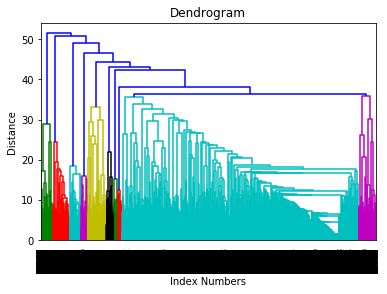

In [52]:
def plot_dendogram(df):
    
    # Data preparation:
    X = df.values
    Z = linkage(X, 'ward')
    
    # Plotting:
    plt.title('Dendrogram')
    plt.xlabel('Index Numbers')
    plt.ylabel('Distance')
    dendrogram(
        Z,
        leaf_rotation=90.,  
        leaf_font_size=8.,
    )
    plt.show()
    
    
plot_dendogram(ingredient_master_cvector_dense)

In [37]:
X = ingredient_master_cvector_dense.values
Z = linkage(X, 'ward')
clusters = fcluster(Z,5, criterion='distance')

with open("assets/clusters.pickle","wb") as file:
    pickle.dump(clusters,file)

In [40]:
clusters.max()

1258

### Represent Recipes as vectors of clusters, instead of vectors of ingredients

In [41]:
ingredient_master_cvector_dense['clusters'] = clusters

In [48]:
ingredient_clusters = pd.DataFrame(ingredient_master,clusters)

In [65]:
ingredient_master_cvector_dense[ingredient_master_cvector_dense['mushroom']==1]['clusters'][:25]

56       615
441      614
451      615
456      127
467      611
623      616
674      589
1055     609
1132     619
1210     615
1595     127
1743     616
1798     612
2016     614
2022     614
2100    1257
2158     612
2251     609
2258     612
2292     616
2333     614
2358     611
2360     617
2370     613
2457     145
Name: clusters, dtype: int32

In [64]:
ingredient_clusters.loc[617,:]

,0
617,porcini mushroom water
617,mushroom mix shitake porcini oyster
617,porcini mushroom ground
617,porcini portobellini mushroom
617,mushroom porcini chanterelle oyster
617,mushroom crimini porcini shiitake
617,porcini shiitake mushroom
617,mushroom porcini oyster chanterelle lobster gehog
617,porcini mushroom cèpe
617,mushroom porcini water


In [72]:
ingredient_clusters.reset_index(inplace=True)

In [77]:
ingredient_clusters.rename(columns={'index':'ingredient cluster',0:'ingredient'},inplace=True)

In [79]:
ingredient_clusters.set_index('ingredient',inplace=True)

## Recommender

I think I need to process ingredients 2 ways. As I did it above, it's fine. I lump all the ingredients together in order to run it through countvectorizer. 

When I prep data for the recommendation engine, I think I need to treat each ingredient, rather than each word as the unit of comparison. Still subject to analysis. I can probably stand it up as.

In [68]:
# reduce extra layer in cookbook
new_cookbook = []
for chapter in cookbook:
    for recipe in chapter:
        new_cookbook.append(recipe)
cookbook = new_cookbook

In [101]:
# this eliminates ingredients that have been wholly reduced to blanks
cookbook_nb = [[ingredient for 
                   ingredient in recipe if ingredient != ''] 
                  for recipe in cookbook]

In [117]:
def cluster_vectors(recipe):
    cv_recipe = [ingredient_clusters.at[ingredient,'ingredient cluster'] for ingredient in recipe]
    return cv_recipe

In [128]:
# re-process ingredient list, this time removing the non-descript words identified above
# getting data ready for recommender

num_cores = multiprocessing.cpu_count()
inputs = tqdm(cookbook_nb)

if __name__ == "__main__":
    cv_cookbook = Parallel(n_jobs=num_cores)(delayed(cluster_vectors)(i) for i in inputs)

100%|██████████| 27638/27638 [00:02<00:00, 9413.97it/s]


## Recommendation Engine

### Build ingredient matrix using countvectorizer

In [151]:
cv_recipes = pd.DataFrame(index=np.arange(len(cv_cookbook)),columns=np.arange(clusters.max()))

In [152]:
for index,cv_recipe in enumerate(cv_cookbook):
    for cv_ingredient in cv_recipe:
        cv_recipes.at[index,cv_ingredient] = 1
cv_recipes.fillna(0,inplace=True)

### Recommender

In [158]:
def mean_center_rows(df):
    return (df.T - df.mean(axis=1)).T

In [159]:
recipes_mc = mean_center_rows(cv_recipes)

In [160]:
recipes_mc.isnull().sum().sum()

0

In [161]:
recipes_mc.head()

,0,1,2,3,4,5,6,7,8,9,...,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258
0,-0.003971,-0.003971,-0.003971,-0.003971,-0.003971,-0.003971,-0.003971,-0.003971,-0.003971,-0.003971,...,-0.003971,-0.003971,-0.003971,-0.003971,-0.003971,-0.003971,-0.003971,-0.003971,-0.003971,-0.003971
1,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,...,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177
2,-0.008737,-0.008737,-0.008737,-0.008737,-0.008737,-0.008737,-0.008737,-0.008737,-0.008737,-0.008737,...,-0.008737,-0.008737,-0.008737,-0.008737,-0.008737,-0.008737,-0.008737,-0.008737,-0.008737,-0.008737
3,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,...,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177,-0.003177
4,-0.002383,-0.002383,-0.002383,-0.002383,-0.002383,-0.002383,-0.002383,-0.002383,-0.002383,-0.002383,...,-0.002383,-0.002383,-0.002383,-0.002383,-0.002383,-0.002383,-0.002383,-0.002383,-0.002383,-0.002383


In [162]:
from sklearn.metrics.pairwise import cosine_similarity

sim_matrix = cosine_similarity(recipes_mc)
recipe_sim = pd.DataFrame(sim_matrix, columns=recipes_mc.index, index=recipes_mc.index)

In [ ]:
import seaborn as sns
sns.heatmap(recipe_sim, annot=True, cmap='coolwarm')

### Inspect Recipe Vectorization

In [212]:
ingredient_cvector_dense.head()

,'1butter pie crust dough,'6large roma tomatoe,'able fish thick,'abtropfg kirschen stein,'acorn squash,'acorn squash roundish,'acorn squashe,'acquerello carnaroli rice,'acting yeast,'agnolotti,...,zucker nachw\xfcrzen',zucker rohrohrzucker,zucker salz wei\xdfer,zucker vanillin zucker,zucker',zuckererbsen,zukali,zup bean ogura bean,zwieb\xe4cke kokos,zwiebelchen
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [213]:
ingredient_word_count = ingredient_cvector_dense.sum(axis=0)    
cw = ingredient_word_count.sort_values(ascending = False)
print(cw[0:100])

cw_dict = dict(cw)

salt                               9930
onion                              6908
sugar                              5220
olive oil                          4688
clove garlic                       4585
butter                             4337
garlic clove                       3947
water                              3535
salt pepper                        3299
purpose flour                      2723
ground black pepper                2685
cilantro                           2426
kosher salt                        2408
lemon juice                        2284
extra virgin olive oil             2206
ginger                             2168
egg                                2094
ground cumin                       1900
pepper                             1835
oregano                            1686
vegetable oil                      1584
chili powder                       1570
black pepper                       1568
milk                               1538
eggs                               1529


In [214]:
cw[30000:30100]

tsbp olive oil                                         1
tso mustard                                            1
tso salt                                               1
tspc palm sugar'                                       1
tspfish sauce                                          1
tsweet potatoe                                         1
ttomatoe                                               1
tturmeric                                              1
tuaca liqueur rum brandy marsala                       1
tubetti ditali pasta                                   1
tubetti pasta                                          1
tuna brine                                             1
tuna salad                                             1
tuna steak aboutinch thick                             1
tuna steak tuna                                        1
tuna steak tuna steak sushi                            1
tuna steak'                                            1
tuna steaks'                   

### More EDA

In [ ]:
# distribution of ingredients in recipes

In [ ]:
# most common, least common ingredients
# before and after non-descript word removal

# 

In [ ]:
# figure out input format?
# maybe input prompt
# or url scrape?

In [ ]:
# inventory the differences
# suggest additional ingredients in order to complete both recipes